In [1]:
import torch
import numpy as np 
import matplotlib.pyplot as plt

from tqdm import tqdm
from models import FFGC

import scipy

In [2]:
## Training parameters
train_steps = 30000
bs = 128 # batch size

# Model parameters
ng = 256 # no. of recurrent units
alpha = 0.9 # loss weighting

In [3]:
# instantiate feedforward model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = FFGC(ng = ng, device = device, alpha = alpha)
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)

In [4]:
loss_history = []
for i in tqdm(range(train_steps)):
    r = torch.rand((bs, 2), device = device)*4*np.pi - 2*np.pi
    loss = model.train_step(inputs = r, labels = r, optimizer = optimizer)
    loss_history.append(loss.item())

100%|██████████| 30000/30000 [00:38<00:00, 772.27it/s]


Text(0, 0.5, 'Loss')

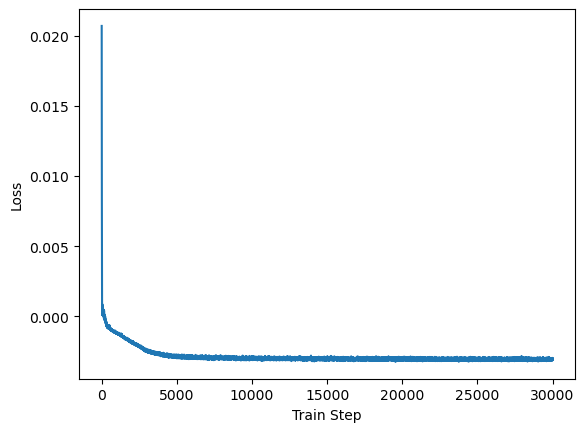

In [5]:
plt.plot(loss_history)
plt.xlabel("Train Step")
plt.ylabel("Loss")

In [6]:
# evaluate on 64x64 grid
x = np.linspace(-1, 1, 128)*2*np.pi
y = np.linspace(-1, 1, 128)*2*np.pi
xx, yy = np.meshgrid(x,y)
r = np.stack([xx.ravel(), yy.ravel()], axis = -1)
gs = model(torch.tensor(r.astype("float32"),device = device))
gs = gs.detach().cpu().numpy()

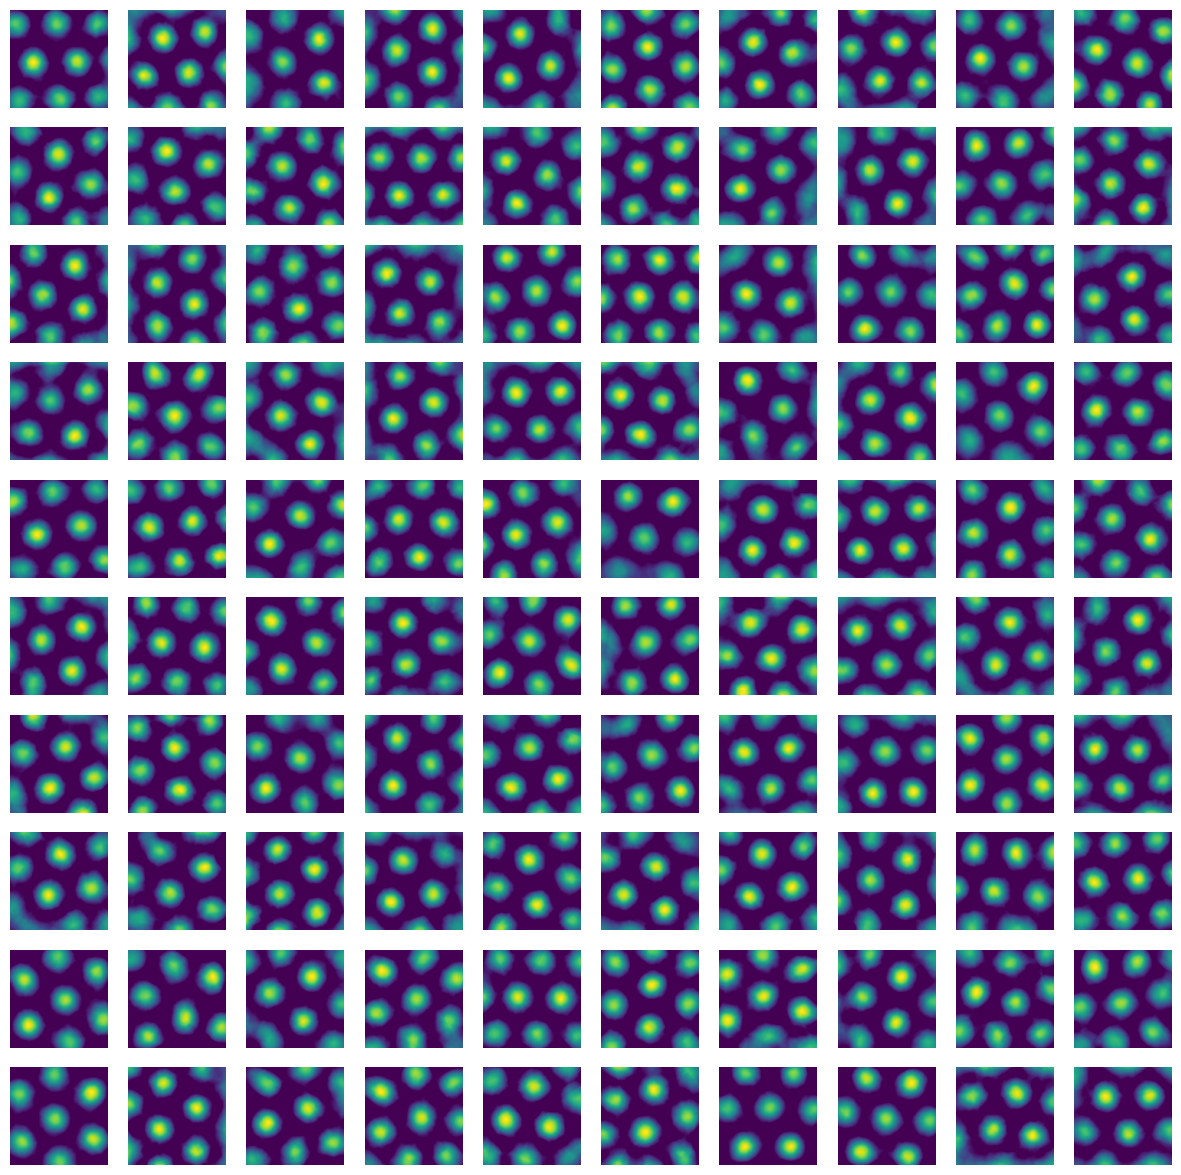

In [7]:
ns = 10 # ns x ns grid of unit ratemaps
count = 0
fig ,ax = plt.subplots(ns,ns, figsize = (15,15))
for i in range(ns):
    for j in range(ns):
        im = ax[i,j].imshow(gs[...,count].reshape(128, 128))
        ax[i,j].axis("off")
        count += 1

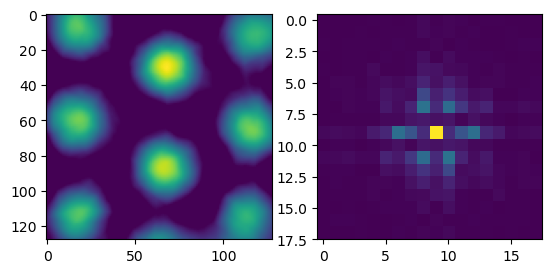

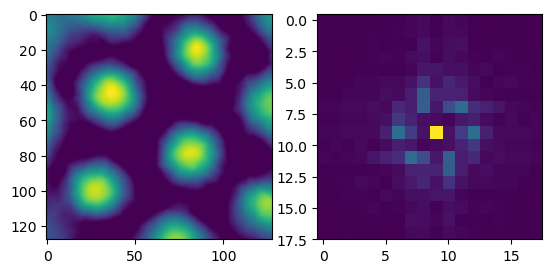

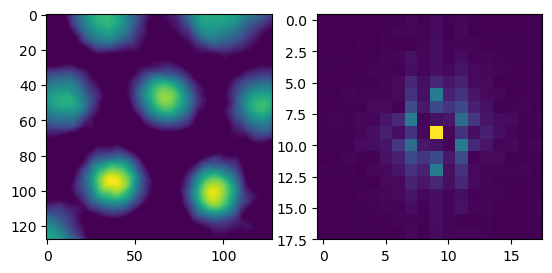

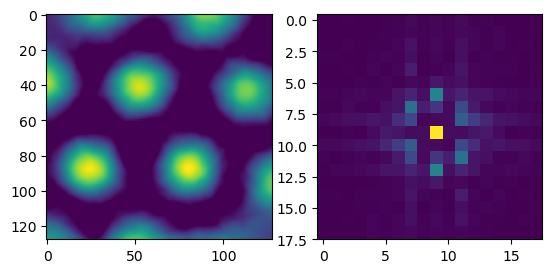

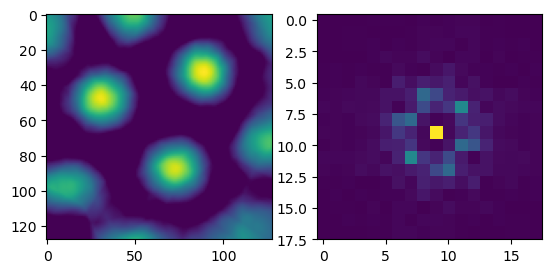

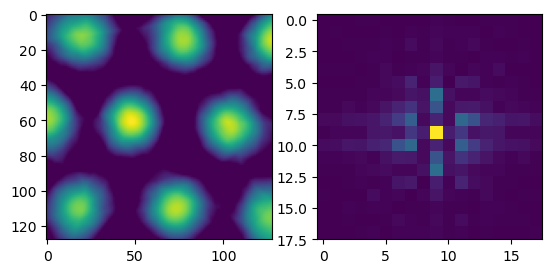

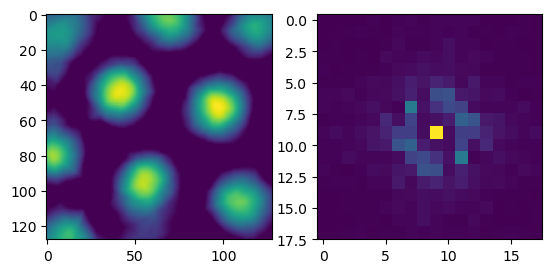

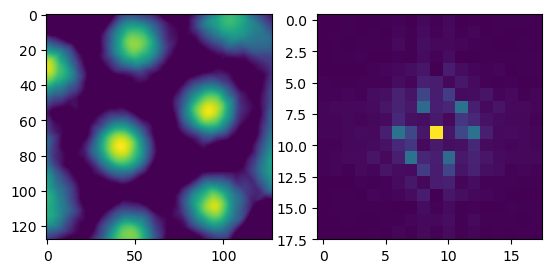

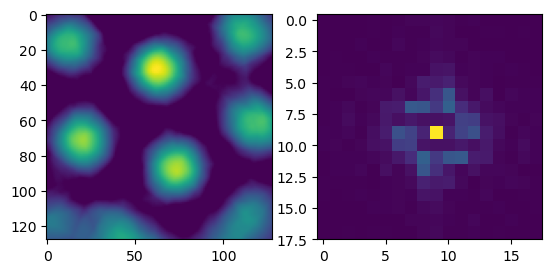

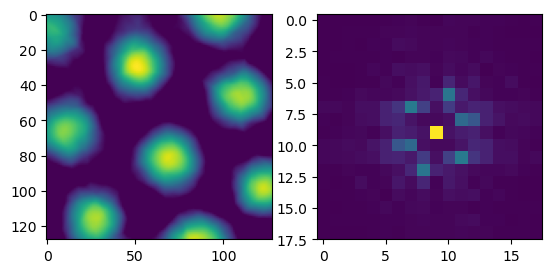

In [8]:
ratemaps = gs.reshape(128,128, -1).T
fft = scipy.fft.fftn(ratemaps, axes=  (1, 2))
fft = scipy.fft.fftshift(fft, (1, 2))
fft = fft[:,55:-55, 55:-55]
for i in range(10):
    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(ratemaps[i])
    ax[1].imshow(np.abs(fft[i]))
    #ax[1].plot(32, 32, "ro")

In [9]:
gs.shape

(16384, 256)

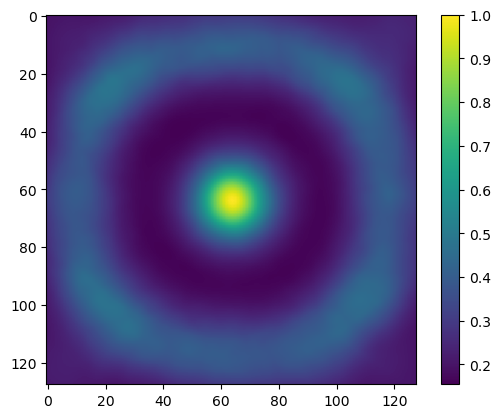

In [10]:
sim = np.exp(np.sum(-(ratemaps - ratemaps[:,64,64][:,None,None])**2, axis = 0))
plt.imshow(sim) # spatial similarity with origin
plt.colorbar()